In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.metrics import accuracy_score, mean_squared_error
import pandas as pd

from sklearn.preprocessing import OneHotEncoder

In [14]:
class FFSN_MultiClass:
  
  def __init__(self, n_inputs, n_outputs, hidden_sizes=[3]):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny] 

    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def softmax(self, x):
    exps = np.exp(x)
    return exps / np.sum(exps)

  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.H[self.nh], self.W[self.nh+1]) + self.B[self.nh+1]
    self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
    return self.H[self.nh+1]
  
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()
 
  def grad_sigmoid(self, x):
    return x*(1-x) 
  
  def cross_entropy(self,label,pred):
    yl=np.multiply(pred,label)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl
 
  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1])) 
    
  def fit(self, X, Y, epochs=100, initialize='True', learning_rate=0.01, display_loss=False):
      
    if display_loss:
      loss = {}
      
    if initialize:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
        
    for epoch in range(epochs):
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x, y in zip(X, Y):
        self.grad(x, y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
                  
      m = X.shape[1]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * (dW[i+1]/m)
        self.B[i+1] -= learning_rate * (dB[i+1]/m)
        
      if display_loss:
        Y_pred = self.predict(X) 
        loss[epoch] = self.cross_entropy(Y, Y_pred)
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      plt.ylabel('CE')
      plt.show()

In [15]:
data = pd.read_csv(r'E:\BITS\Yr 3 Sem 2\BITS F464 Machine Learning\Assignments\Assignment 2\2B\dataset_NN.csv')

In [16]:
data.head()

,att1,att2,att3,att4,att5,att6,class
0,1.0,0.0,0.0,133.150861,1.311693,1620.221779,1
1,1.0,0.0,0.0,126.724861,1.302745,1609.334822,1
2,1.0,0.0,0.0,131.173861,1.319031,1568.978435,1
3,1.0,0.0,0.0,129.478861,1.270878,1695.055281,1
4,1.0,0.0,0.0,127.262861,1.329637,1647.720235,1


In [17]:
def process(data):
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    X = (X-X.mean(axis= 0)) / X.std(axis= 0)

    return X, y

In [18]:
X, y = process(data)

In [19]:
def split_train_test(X, y, split, seed):

    #creating the training and testing dataset
    rows = int(X.shape[0] * split)
    indices = np.arange(X.shape[0])
    np.random.seed(seed)
    np.random.shuffle(indices)
    train = indices[:rows]
    test = indices[rows:]

    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    return X_train, y_train, X_test, y_test

In [20]:
X_train, y_train, X_test, y_test = split_train_test(X, y, 0.7, 23)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [21]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(y_train,1)).toarray()
y_OH_test = enc.fit_transform(np.expand_dims(y_test,1)).toarray()

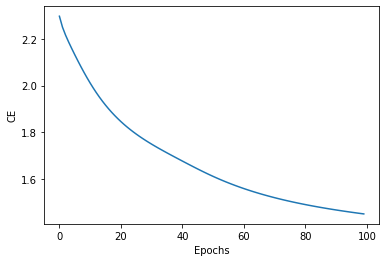

In [22]:
# For 2 hidden layers
# lr = 0.01
nn = FFSN_MultiClass(X_train.shape[1], len(y.unique()), hidden_sizes= [2])
nn.fit(X_train, y_OH_train, display_loss= True)

In [23]:
predictions = nn.predict(X_test)

In [24]:
predictions = predictions.astype(int).ravel()
y_OH_test = y_OH_test.astype(int).ravel()

In [25]:
accuracy_test = accuracy_score(predictions, y_OH_test)
print(accuracy_test)

0.9


<ipython-input-23-c9483c962252>:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


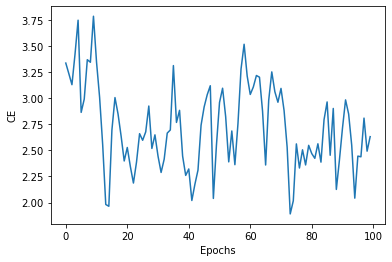

In [35]:
# For 2 hidden layers
# lr = 0.1
nn = FFSN_MultiClass(X_train.shape[1], len(y.unique()), hidden_sizes= [2])
nn.fit(X_train, y_OH_train, display_loss= True, learning_rate= 0.1)

In [33]:
predictions = nn.predict(X_test)

In [27]:
predictions = predictions.astype(int).ravel()
y_OH_test = y_OH_test.astype(int).ravel()

In [28]:
accuracy_test = accuracy_score(predictions, y_OH_test)
print(accuracy_test)

0.9


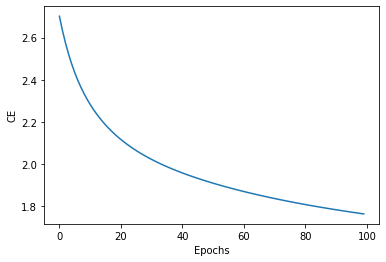

In [29]:
# For 2 hidden layers
# lr = 0.001
nn = FFSN_MultiClass(X_train.shape[1], len(y.unique()), hidden_sizes= [2])
nn.fit(X_train, y_OH_train, display_loss= True, learning_rate= 0.001)

In [30]:
predictions = nn.predict(X_test)

In [31]:
predictions = predictions.astype(int).ravel()
y_OH_test = y_OH_test.astype(int).ravel()

In [32]:
accuracy_test = accuracy_score(predictions, y_OH_test)
print(accuracy_test)

0.9


<ipython-input-23-c9483c962252>:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


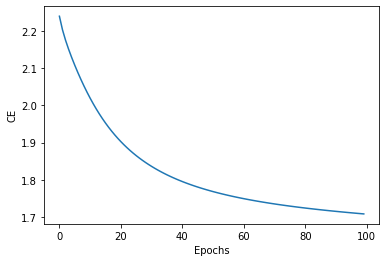

In [43]:
# For 1 hidden layer
# lr = 0.01
nn = FFSN_MultiClass(X_train.shape[1], len(y.unique()), hidden_sizes= [1])
nn.fit(X_train, y_OH_train, display_loss= True)

In [34]:
predictions = nn.predict(X_test)

In [35]:
predictions = predictions.astype(int).ravel()
y_OH_test = y_OH_test.astype(int).ravel()

In [36]:
accuracy_test = accuracy_score(predictions, y_OH_test)
print(accuracy_test)

0.9


<ipython-input-23-c9483c962252>:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


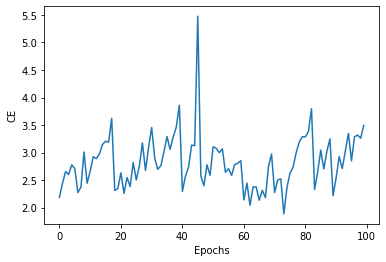

In [47]:
# For 1 hidden layer
# lr = 0.1
nn = FFSN_MultiClass(X_train.shape[1], len(y.unique()), hidden_sizes= [1])
nn.fit(X_train, y_OH_train, display_loss= True, learning_rate= 0.1)

In [37]:
predictions = nn.predict(X_test)

In [38]:
predictions = predictions.astype(int).ravel()
y_OH_test = y_OH_test.astype(int).ravel()

In [39]:
accuracy_test = accuracy_score(predictions, y_OH_test)
print(accuracy_test)

0.9


<ipython-input-23-c9483c962252>:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


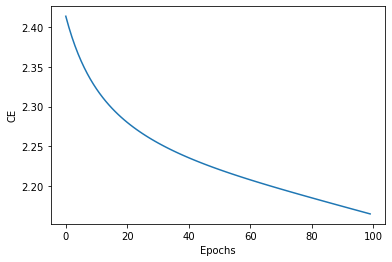

In [51]:
# For 1 hidden layer
# lr = 0.001
nn = FFSN_MultiClass(X_train.shape[1], len(y.unique()), hidden_sizes= [1])
nn.fit(X_train, y_OH_train, display_loss= True, learning_rate= 0.001)

In [40]:
predictions = nn.predict(X_test)

In [41]:
predictions = predictions.astype(int).ravel()
y_OH_test = y_OH_test.astype(int).ravel()

In [42]:
accuracy_test = accuracy_score(predictions, y_OH_test)
print(accuracy_test)

0.9
